# Kaggle Data Challenge
## Kernel methods in machine learning

</br>

Since we regularly implemented the code and updated the boxes, each time the previpus output of boxes was deleted!
For this reason, we have regenerated the results once again to
show the advances we had along the challenge.

*As a funny thing, we obtained better results while regenerating, at least in the level of cross validation.*

In [ ]:
# If you implement the code on colab, run this box:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# This box imports the required libraries.
import csv
import numpy as np

# By uncommenting the following line, you can set the maxiters of cvxopt algorithm to whatever you want.
import cvxopt
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 15


import sklearn.model_selection as select
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import pandas as pd


print("Libraries imported!")

Libraries imported!


 The following box, read matrices Xtr.csv and Xte.csv as DATA and TEST respectively, also reading labels from Ytr.csv.

In [ ]:
dir = '/content/gdrive/MyDrive/Colab Notebooks/Kernel methods/CSVs/'

file = open(dir+'Xtr.csv')
stream = csv.reader(file)
row = next(stream)
row.pop()
DATA = np.array([float(x) for x in row])
for i in range(1,5000):
    row = next(stream)
    row.pop()
    row = np.array([float(x) for x in row])
    DATA = np.vstack([DATA, row])
file.close()


labels = []
file = open(dir+'Ytr.csv')
stream = csv.reader(file)
row = next(stream)
for i in range(5000):
    row = next(stream)
    labels.append(int(row[1]))
labels = np.array(labels)
file.close()


file = open(dir+'Xte.csv')
stream = csv.reader(file)
row = next(stream)
row.pop()
TEST = np.array([float(x) for x in row])
for i in range(1,2000):
    row = next(stream)
    row.pop()
    row = np.array([float(x) for x in row])
    TEST = np.vstack([TEST, row])
file.close()


print("Data read!")

Data read!


## Kernel trick methods (KRR, KLR and SVM)
The following box is dedicated to the different kernel trick methods.
The elapsed time for a single training is

* **KRR:** 2-3 seconds
* **KLR:** 10-15 seconds
* **SVM (cvxopt):** 1m 30s - 3m 30s (preferably for $\lambda < 0.01$)
* **SVM (coordinate ascent):** 1-4 seconds (depending on maxiters)

The function `predictor` takes the train data set, test data set, $\alpha$ and $\sigma$ of RBF kernel and returns back the vector of the predictions over the whole test data set. In other words, for train data set $x_1,\dotsc, x_n$ it returns back the vector of 

$$ \sum_i \alpha_i K_{\sigma}(x_i,d),$$
for all d in the test data set.



In [ ]:
### Kernel Logistic ###

def sigma(vect):
    return 1/(1 + np.exp(-vect))

def update_w_z(K, alpha, y):
    m = np.matmul(K, alpha)
    p = -sigma(-y*m)
    w = sigma(m)*sigma(-m)
    z = m - p*y/w
    return w,z


def solveWKRR(K, w, z, Lambda, dim):
    A = (((np.sqrt(w)*K).T)*np.sqrt(w) + Lambda*dim*np.identity(dim))*(1/np.sqrt(w))
    b = np.sqrt(w)*z
    return np.linalg.solve(A, b)


def kernel_logistic(K, y, Lambda):
    dim = len(y)
    error = 1
    alpha = np.zeros((dim,))
    while error > .0000001:
        w, z = update_w_z(K, alpha, y)
        alpha_old = np.copy(alpha)
        alpha = solveWKRR(K, w, z, Lambda, dim)
        error = np.linalg.norm(alpha - alpha_old, ord=2)
    return alpha


################################################################

### Kernel Ridge Rigression ###

def kernel_ridge_regression(K, y, Lambda):
    dim = len(y)
    A = K + Lambda*dim*np.identity(dim)
    return np.linalg.solve(A, y)


################################################################

### Kernel SVM (cvxopt) ###

def svm_solver(K, y, Lambda):
    dim = len(y)
    G = np.vstack([-np.diag(y), np.diag(y)])
    h = np.hstack((np.zeros(dim), (1/(2*Lambda*dim))*np.ones(dim)))
    P = cvxopt.matrix(K)
    q = cvxopt.matrix(-y)
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    solution = cvxopt.solvers.qp(P, q, G, h, A=None, b=None)
    solution = np.ravel(solution['x'])
    return solution


################################################################

### Kernel SVM (coordinate ascent) ###

# The following function projects x onto the interval [0,a] if a > 0 ([a,0] if a < 0)
def projection(x, a):
    if 0 < a:
     return min(max(0,x),a)
    else:
     return min(max(a,x),0)


def svm_co_ascent(K, y, Lambda, maxiters):
    dim = len(y)
    alpha = np.zeros(dim)
    c = 1/(2*Lambda*dim)
    for iter in range(maxiters):
    #while error > .0001:
      #alpha_old = np.copy(alpha)
      for i in range(dim):
        tmp = ((y[i]-np.dot(alpha,K[i]))/K[i,i]) + alpha[i]
        alpha[i] = projection(tmp, c*y[i])
      #error = np.linalg.norm(alpha - alpha_old, ord=2)
    return alpha


#################################################################

def predictor(train_dataset, test_dataset, alpha, Sigma):
    D = euclidean_distances(test_dataset, train_dataset, squared=True)
    return np.matmul(np.exp((-1/(2*Sigma**2))*D), alpha)

def gram_matrix(train_dataset, Sigma):
    D = euclidean_distances(train_dataset, train_dataset, squared=True)
    return np.exp((-1/(2*Sigma**2))*D)
    
    
print("Done!")

Done!


The following box,
* builds an empty data frame for displaying the results,
* initialize the cross validation settings, like number of folds and a list of column names required for the data frame,
* creates an array of size (5000,10) of binary labels for the OvR purpose.

In [ ]:
# Initialize a data frame for displaying the results
df = pd.DataFrame()

############ Cross Validation Settings #############
n_splits = 10
folds_list = ['Fold '+str(i) for i in range(n_splits)]
folds_list.append('Average')

############## Create binary labels ################
y = np.zeros((5000,10))
for l in range(10):
    y.T[l] = np.array([1. if labels[i] == l else -1. for i in range(len(DATA))])
    
print('Done!')

Done!


## Training model based on different parameters

The following box trains a model based on the parameters $\sigma_0, \dotsc, \sigma_9$ and $\lambda_0 , \dotsc, \lambda_9$. It is worth mentioning that

* it uses 10-folds cross validation and for each fold it trains 10 classifiers, hence, the overall elapsed time is, at least, 100 times more than what is given in the above boxes,

* instead of computing gram matrices 100 times, we compute the gram matrices on the whole data set 10 times, one per each $\sigma$, and then use their minor matrices for obtaining the final gram matrices. This way, we will save 3-4 minutes in the whole process,

* you can change the kernel to `svm_solver`, `svm_co_ascent` and `kernel_logistic`. Note that `svm_co_ascent` takes an extra argument (the last one) for the maximum number of iterations. You can set it to 50 for $\lambda = 0.1$ and 200 for $\lambda = 0.01$. For smaller $\lambda$'s it is strongly recommended to use `svm_solver`,

* Once you are done with the following box, you can go to the next box for displaying the results.

In our first submission, we set all the $\sigma$'s to 1.8 and all the $\lambda$'s to 0.00001. In our second submission, we used $\sigma$'s and $\lambda$'s in the first two lines of the following box.


In [ ]:
#Sigmas = [1.6, 2.6, 1.7, 1.1, 1.6, 1.8, 2.6, 1.8, 2.1, 1.6]
#Lambdas = [.0001, .00001, .00001, .00001, .000001, .00001, .00001, .00001, .00001, .000001]

#Sigmas = [2]*10
#Lambdas = [.00001]*10

#Sigmas = [4]*10
#Lambdas = [.1]*10

kf = select.KFold(n_splits=n_splits)
folds = kf.split(DATA)

results = []

K = {}
for i in range(10):
    K[i] = gram_matrix(DATA, Sigmas[i])

for train_idx, val_idx in folds:
    train = DATA[train_idx]
    val = DATA[val_idx]
    y_train = y[train_idx]
    P = np.zeros((10,len(val)))
    alphas = {}
    for l in range(10):
        K_minor = (K[l][train_idx]).T[train_idx]
        alphas[l] = kernel_ridge_regression(K_minor, y_train.T[l], Lambdas[l])
        P[l] = predictor(train, val, alphas[l], Sigmas[l])
    preds = [np.argmax(P.T[i]) for i in range(len(val))]
    accuracy = 100*np.sum(preds == labels[val_idx])/len(val)
    results.append(accuracy)

results.append(np.mean(np.array(results)))

print('Done!')

Done!


## Kernel Ridge Regression
The following table illustrates the results of training a model based on kernel ridge regression for different values of parameters. Training each model along with the cross validation process takes 5m - 6m. Each line in the table corresponds to different parameters. The 8th line corresponds to our second submission. As you may see, while regenrating the results, we obtain better models, at least in the level of cross validation.

In [ ]:
if df.empty:
  df = pd.DataFrame([results], columns=folds_list)
else:
  df = df.append(pd.DataFrame([results], columns=folds_list), ignore_index=True)

df

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Average
0,20.0,23.2,21.2,18.6,21.6,16.0,20.6,18.8,19.6,19.0,19.86
1,19.8,25.4,20.4,18.4,19.4,16.6,22.0,20.0,18.4,19.2,19.96
2,22.2,21.6,19.4,19.0,22.4,19.4,21.6,17.8,22.0,19.4,20.48
3,18.4,22.6,19.8,17.6,18.4,17.2,23.0,19.6,18.2,19.4,19.42
4,19.0,21.6,19.4,17.4,19.4,17.4,24.2,20.6,20.2,20.0,19.92
5,19.8,21.6,17.2,18.2,21.0,17.8,23.6,21.6,20.0,20.2,20.10
6,22.2,24.2,19.4,23.4,22.8,19.6,24.8,23.0,22.4,23.4,22.52
7,23.0,23.0,20.8,21.4,23.2,21.0,24.2,21.2,24.6,24.2,22.66
8,24.0,22.0,19.8,22.4,24.0,20.2,26.4,22.6,24.6,21.6,22.76
9,24.6,22.2,20.4,21.2,23.2,22.0,26.8,23.2,26.4,23.2,23.32


## Kernel Logistic

The following table illustrates the results of training a model based on kernel logistic regression for different values of parameters. Training each model along with the cross validation process takes 30m.

The first line and the second line correspond respectively to $\sigma = 2,3$ and $\lambda = 0.00001$ for all classifiers.

You may have noticed that the final results are almost the same as KRR.

In [ ]:
if df.empty:
  df = pd.DataFrame([results], columns=folds_list)
else:
  df = df.append(pd.DataFrame([results], columns=folds_list), ignore_index=True)

df

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Average
0,22.8,23.0,18.4,20.8,22.4,17.0,23.2,21.2,23.0,20.4,21.22
1,20.0,21.0,18.0,19.2,22.2,17.4,22.6,19.0,21.8,19.0,20.02


## Kernel SVM

The following table illustrates the results of training a model based on kernel SVM for different values of parameters.

The first three lines correspond respectively to $\sigma = 2,3,4$ and $\lambda = 0.01$ for all classifiers. Also, the second three lines correspond respectively to $\sigma = 2,3,4$ and $\lambda = 0.1$ for all classifiers.

Unfortunately, because we had not much time to regenerate results for smaller $\lambda$'s, we were not able to provide them here. Note that with cross validation and using the `cvxopt` library, it takes 2h 30m - 6h, at minimum to produce one line of results! However, we tested `svm_solver` without cross validation by just choosing 4500 random rows from the whole data set and the rest as the test data set. After 25m of training process we got a model of 28% accuracy, which indicates the strength of SVM over other kernel methods. But at the end of the day, for
producing the final results and train the model, we got back to KRR.

Note that in the following table we have used `svm_co_ascent` function. for $\lambda = 0.1$ we have set `maxiters = 50` which took 4m 45s and for $\lambda = 0.01$ we have set `maxiters = 200` which took 13m 45s for the algorithm to complete.



In [ ]:
if df.empty:
  df = pd.DataFrame([results], columns=folds_list)
else:
  df = df.append(pd.DataFrame([results], columns=folds_list), ignore_index=True)

df

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Average
0,16.8,16.8,16.0,16.0,15.6,16.8,15.6,17.2,13.8,13.4,15.80
1,17.0,15.6,15.8,16.0,16.0,15.0,18.0,17.6,14.0,14.4,15.94
2,17.0,14.8,14.0,13.8,16.8,16.6,15.2,14.0,14.8,13.8,15.08
3,14.6,15.0,16.8,14.6,14.4,15.2,17.0,15.2,14.6,12.4,14.98
4,15.8,12.4,13.2,11.8,12.0,12.6,13.2,17.6,9.4,10.4,12.84
5,16.2,16.4,16.4,16.8,15.8,13.4,15.2,12.4,19.2,10.6,15.24


## Histogram Trick

See the pdf file for more datails on this trick.

In our third submission, we set `b` as a partition of the interval [-0.49,0.424] into 456 sub-intervals with the same length.

In [ ]:
# range of DATA and TEST vectors is [-0.4904328, 0.4238609]
#b = np.arange(-245,212)/500

def build_bins(n, s):
  b = np.array([x*np.exp(x**2/(2*s)) for x in np.arange(-n,n)/(2*n)])
  b = (-.490/b[0]) * b
  b = b[b < .424]
  return b

def histogram_trick(dataset, n, s):
  n_rows, n_columns = dataset.shape
  n_RGB = int(n_columns/3)
  b = build_bins(n,s)
  new_dataset = np.zeros((n_rows, 3*(len(b)-1)))
  for i in range(n_rows):
    R,_ = np.histogram(dataset[i,:n_RGB], bins=b, density=True)
    G,_ = np.histogram(dataset[i,n_RGB:n_RGB*2], bins=b, density=True)
    B,_ = np.histogram(dataset[i,n_RGB*2:], bins=b, density=True)
    new_dataset[i] = np.hstack((R,G,B))
  return new_dataset

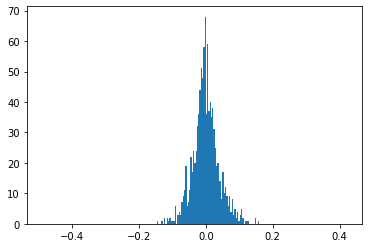

In [ ]:
# This box is not required! We just set it here for displaying the histograms.
_ = plt.hist(DATA[5,:1024], bins=build_bins(100, .5))

The following box converts rows of DATA and TEST into their histogram vectors! 

In [ ]:
data = histogram_trick(DATA, 100, .5)
test = histogram_trick(TEST, 100, .5)

print('Done!')

Done!


The following box trains a model based on the histograms of data. Again, we have used KRR.

The first two lines are the parameters of our third submission!

In [ ]:
#Sigmas = [25, 25, 35, 32, 30, 25, 32, 40, 33, 47]
#Lambdas = [.001, .001, .0001, .001, .001, .001, .001, .0001, .001, .001]

Sigmas = [60]*10
Lambdas = [.0001]*10

kf = select.KFold(n_splits=n_splits)
folds = kf.split(data)

results = []

K = {}
for i in range(10):
    K[i] = gram_matrix(data, Sigmas[i])

for train_idx, val_idx in folds:
    train = data[train_idx]
    val = data[val_idx]
    y_train = y[train_idx]
    P = np.zeros((10,len(val)))
    alphas = {}
    for l in range(10):
        K_minor = (K[l][train_idx]).T[train_idx]
        alphas[l] = kernel_ridge_regression(K_minor, y_train.T[l], Lambdas[l])
        P[l] = predictor(train, val, alphas[l], Sigmas[l])
    preds = [np.argmax(P.T[i]) for i in range(len(val))]
    accuracy = 100*np.sum(preds == labels[val_idx])/len(val)
    results.append(accuracy)

results.append(np.mean(np.array(results)))

print('Done!')

Done!


## And the results!

You may have noticed that using histograms of data, instead of raw data themselves, increases significantly the accuracy of the model.

The parameters of our last submission were $\sigma = 60$ and $\lambda = 0.0001$ for all classifiers which corresponds to the 4th line of the following table.

Again, we were able to regenerate better models!

In [ ]:
if df.empty:
  df = pd.DataFrame([results], columns=folds_list)
else:
  df = df.append(pd.DataFrame([results], columns=folds_list), ignore_index=True)

df

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Average
0,31.6,29.6,34.6,30.6,30.6,31.4,33.0,29.2,35.2,33.0,31.88
1,33.2,29.2,33.6,28.8,29.0,30.6,31.4,32.2,34.2,31.0,31.32
2,33.4,30.6,35.6,29.8,31.0,31.6,32.0,32.2,37.2,30.2,32.36
3,32.0,30.4,34.8,30.2,30.8,32.0,33.8,32.6,36.2,31.2,32.40
4,32.2,29.4,33.8,29.6,29.4,32.2,32.2,32.0,36.6,33.6,32.10
5,31.4,29.2,33.4,28.4,30.2,32.0,31.6,32.2,36.2,33.2,31.78


# Training the model

Now that we have found good parameters, we can train a model with these parameters on the whole data set.

The following box does this.

In [ ]:
Sigmas = [60]*10
Lambdas = [.0001]*10

P = np.zeros((10,len(test)))
alphas = {}
for l in range(10):
    K = gram_matrix(data, Sigmas[l])
    alphas[l] = kernel_ridge_regression(K, y.T[l], Lambdas[l])
    P[l] = predictor(data, test, alphas[l], Sigmas[l])
    
preds = [np.argmax(P.T[i]) for i in range(len(test))]

print('finished')

finished


The following box saves the labels obtained by the model in Yte_pred.csv

In [ ]:
file = open(dir+'Yte_pred.csv','w')
stream = csv.writer(file)
row = ['Id', 'Prediction']
stream.writerow(row)
for i in range(2000):
    row = [i+1,preds[i]]
    stream.writerow(row)
file.close()